### Choice of the repurchase date 

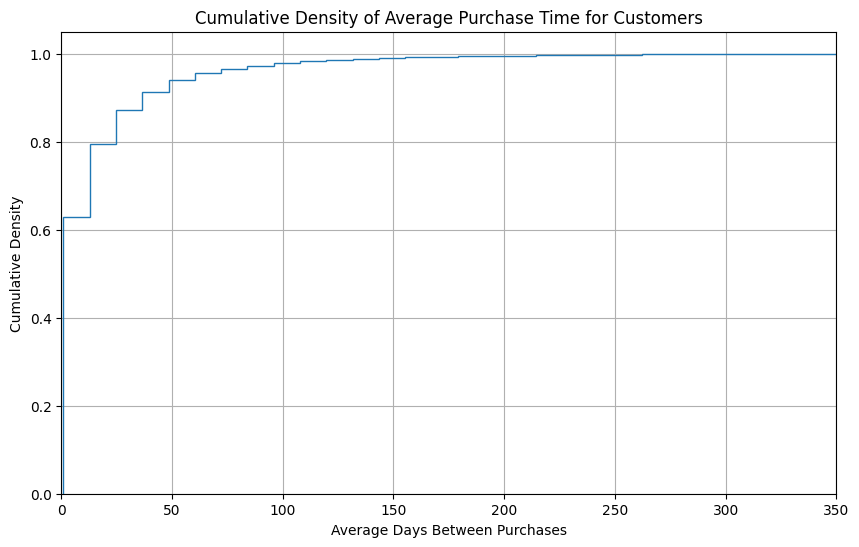

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the tables
customers = pd.read_csv('tbl_customers.csv')
orders = pd.read_csv('tbl_orders.csv')

# Convert purchase_datetime to datetime
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])

# Remove duplicates
orders = orders.drop_duplicates()

# Sort the orders by customer_id and purchase_datetime
orders = orders.sort_values(by=['customer_id', 'purchase_datetime'])

# Calculate the time between purchases
orders['previous_purchase'] = orders.groupby('customer_id')['purchase_datetime'].shift(1)
orders['days_between'] = (orders['purchase_datetime'] - orders['previous_purchase']).dt.days

# Ensure that any non-zero time differences are at least one day
orders['days_between'] = orders['days_between'].apply(lambda x: max(x, 1) if pd.notnull(x) else x)

# Remove customers with less than 2 transactions
customer_transaction_counts = orders['customer_id'].value_counts()
customers_with_enough_transactions = customer_transaction_counts[customer_transaction_counts > 1].index
filtered_orders = orders[orders['customer_id'].isin(customers_with_enough_transactions)]

# Calculate the average purchase time for each customer
average_purchase_time = filtered_orders.groupby('customer_id')['days_between'].mean().dropna()

# Filter out the zeros
average_purchase_time = average_purchase_time[average_purchase_time > 0]

# Plot the cumulative histogram as a density curve
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(average_purchase_time, bins=30, density=True, cumulative=True, histtype='step', alpha=1)
plt.title('Cumulative Density of Average Purchase Time for Customers')
plt.xlabel('Average Days Between Purchases')
plt.ylabel('Cumulative Density')
plt.grid(True)
plt.xlim([0,350])
plt.show()

In [2]:
percentile_85 = np.percentile(average_purchase_time, 85)
print(f"The value such that 85% of the customers repurchase within this time interval is: {percentile_85} days")

The value such that 85% of the customers repurchase within this time interval is: 32.25 days


In [3]:
average_purchase_time

customer_id
23         4.486486
30        14.333333
32         2.400000
48         4.671642
50        11.333333
            ...    
934324     1.000000
934335     1.000000
934389     1.000000
934484     1.000000
934620     1.000000
Name: days_between, Length: 87299, dtype: float64

In [1]:
import pandas as pd

# Load the data
orders = pd.read_csv('tbl_orders.csv')

# Convert purchase_datetime to datetime
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])

# Inspect the date range in the orders dataset
print("Min date:", orders['purchase_datetime'].min())
print("Max date:", orders['purchase_datetime'].max())

Min date: 2022-05-01 07:19:05
Max date: 2023-04-30 21:11:41


Lookback orders shape: (545044, 8)
RFM head:
    customer_id  recency  frequency  monetary
0           23       10         34    454.89
1           30      161         11  10176.46
2           48        2         50    532.82
3           60       18          1     49.98
4           95       82          3      6.25
Churn status head:
    customer_id  orders_in_holdout  churn
0           48                  9  False
1           50                  2  False
2          136                  5  False
3          205                  2  False
4          216                  1  False
Data head:
    customer_id  recency  frequency  monetary  churn
0           23       10         34    454.89      1
1           30      161         11  10176.46      1
2           48        2         50    532.82      0
3           60       18          1     49.98      1
4           95       82          3      6.25      1
X shape: (68795, 3)
y shape: (68795,)


C:\Users\Utente\AppData\Local\Temp\ipykernel_18108\2342840381.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['churn'] = data['churn'].fillna(True).astype(int)  # Assume customers with no orders in holdout period as churned


Confusion Matrix:
[[  837  3341]
 [ 1735 14726]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25      4178
           1       0.82      0.89      0.85     16461

    accuracy                           0.75     20639
   macro avg       0.57      0.55      0.55     20639
weighted avg       0.72      0.75      0.73     20639


ROC AUC Score:
0.6149461981725726


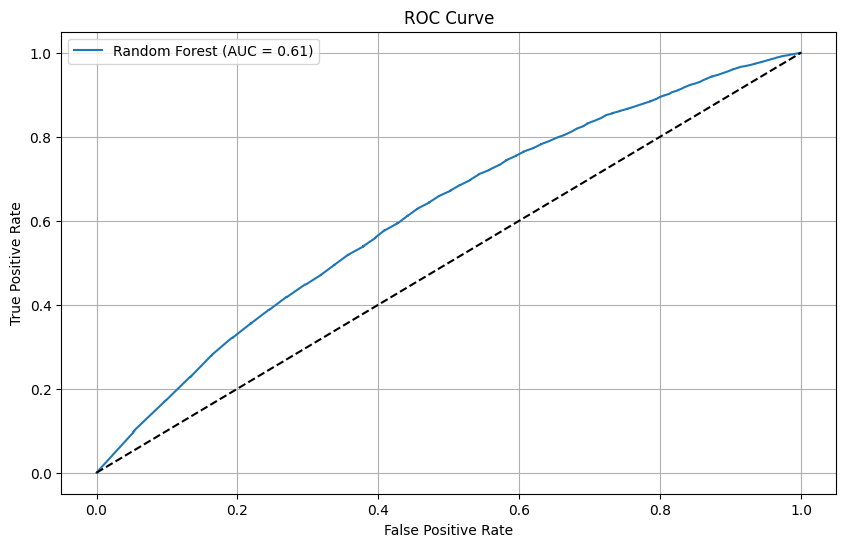

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load the data
customers = pd.read_csv('tbl_customers.csv')
orders = pd.read_csv('tbl_orders.csv')

# Convert purchase_datetime to datetime
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])

# Adjust the reference date based on the dataset date range
reference_date = pd.Timestamp('2023-1-01')  

# Imposing the holdout period (33 days)
holdout_period = timedelta(days=33)
holdout_end_date = reference_date + holdout_period

# Define a lookback period (e.g., 180 days)
lookback_period = timedelta(days=180)
lookback_start_date = reference_date - lookback_period

# Filter orders within the lookback period
lookback_orders = orders[(orders['purchase_datetime'] >= lookback_start_date) & 
                         (orders['purchase_datetime'] < reference_date)]

# Debug: Print lookback_orders shape
print("Lookback orders shape:", lookback_orders.shape)

# Compute RFM values
rfm = lookback_orders.groupby('customer_id').agg({
    'purchase_datetime': lambda x: (reference_date - x.max()).days,  # Recency
    'order_id': 'count',                                            # Frequency
    'gross_price': 'sum'                                            # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Debug: Print RFM head
print("RFM head:\n", rfm.head())

# Determine churn status based on the holdout period
holdout_orders = orders[(orders['purchase_datetime'] >= reference_date) & 
                        (orders['purchase_datetime'] < holdout_end_date)]

churn_status = holdout_orders.groupby('customer_id').size().reset_index(name='orders_in_holdout')
churn_status['churn'] = churn_status['orders_in_holdout'] == 0

# Debug: Print churn_status head
print("Churn status head:\n", churn_status.head())

# Merge RFM values with churn status
data = pd.merge(rfm, churn_status[['customer_id', 'churn']], on='customer_id', how='left')
data['churn'] = data['churn'].fillna(True).astype(int)  # Assume customers with no orders in holdout period as churned

# Debug: Print data head
print("Data head:\n", data.head())

# Define features and target
X = data[['recency', 'frequency', 'monetary']]
y = data['churn']

# Debug: Print X and y shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Check if there are any samples in X
if X.shape[0] == 0:
    raise ValueError("No data available for training. Check your filtering steps.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()